In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, Tuple
from matplotlib.ticker import ScalarFormatter

In [2]:
def load_tracking_results(json_path: str) -> Dict:
    """Load tracking results from JSON file."""
    json_path = Path(json_path)
    if not json_path.exists():
        raise FileNotFoundError(f"No results file found at {json_path}")
    
    with open(json_path, 'r') as f:
        all_results = json.load(f)
    
    return all_results


def parse_scenario_name(scenario: str) -> Tuple[int, int]:
    """Parse scenario name to extract number of layers and tracks."""
    parts = scenario.replace('[', '').replace(']', '').split('_')
    n_layers = int(parts[0].replace('L', ''))
    n_tracks = int(parts[1].replace('T', ''))
    return n_layers, n_tracks


def calculate_matrix_size(n_layers: int, n_tracks: int) -> int:
    """Calculate the matrix size N from number of layers and tracks."""
    return (n_layers - 1) * n_tracks**2


def calculate_hellinger_fidelity(dist1: np.ndarray, dist2: np.ndarray) -> float:
    """Calculate Hellinger fidelity between two probability distributions."""
    return np.sum(np.sqrt(dist1 * dist2)) ** 2


def identify_track_bins(scenario_data: Dict,
                        baseline_emulator: str = 'H2-1LE',
                        circuit_type: str = '1BIT_2bin_2level',
                        threshold: float = 1e-10) -> np.ndarray:
    """Identify which bins correspond to valid tracks using the noiseless baseline."""
    baseline_mean = np.array(
        scenario_data[baseline_emulator][circuit_type]['normalized_vectors']['mean']
    )
    track_mask = baseline_mean > threshold
    return track_mask


def calculate_signal_separation_index(measured_dist: np.ndarray,
                                      track_mask: np.ndarray) -> float:
    """Calculate Signal Separation Index (SSI)."""
    track_probs = measured_dist[track_mask]
    noise_probs = measured_dist[~track_mask]
    
    if len(track_probs) == 0 or len(noise_probs) == 0:
        return np.nan
    
    mean_track = np.mean(track_probs)
    
    n_track_bins = len(track_probs)
    n_top_noise = min(n_track_bins, len(noise_probs))
    top_noise_probs = np.sort(noise_probs)[-n_top_noise:]
    mean_noise = np.mean(top_noise_probs)
    
    if mean_noise < 1e-15:
        return np.inf if mean_track > 1e-15 else 1.0
    
    return mean_track / mean_noise


def compute_hellinger_with_errors(tracking_results: Dict,
                                   baseline_emulator: str = 'H2-1LE',
                                   circuit_type: str = '1BIT_2bin_2level',
                                   n_bootstrap: int = 1000) -> Dict:
    """Compute Hellinger fidelity vs baseline with error estimation."""
    results = {}
    
    for scenario, scenario_data in tracking_results.items():
        results[scenario] = {}
        baseline_mean = np.array(
            scenario_data[baseline_emulator][circuit_type]['normalized_vectors']['mean']
        )
        baseline_std = np.array(
            scenario_data[baseline_emulator][circuit_type]['normalized_vectors']['std']
        )

        for emulator in scenario_data.keys():
            if emulator == baseline_emulator:
                continue
            
            emulator_mean = np.array(
                scenario_data[emulator][circuit_type]['normalized_vectors']['mean']
            )
            emulator_std = np.array(
                scenario_data[emulator][circuit_type]['normalized_vectors']['std']
            )
            
            # Bootstrap to estimate metric error
            metric_samples = []
            
            for _ in range(n_bootstrap):
                baseline_sample = np.random.normal(baseline_mean, baseline_std)
                emulator_sample = np.random.normal(emulator_mean, emulator_std)
                
                baseline_sample = np.maximum(0, baseline_sample)
                baseline_sample /= np.sum(baseline_sample)
                
                emulator_sample = np.maximum(0, emulator_sample)
                emulator_sample /= np.sum(emulator_sample)
                
                metric_value = calculate_hellinger_fidelity(baseline_sample, emulator_sample)
                metric_samples.append(metric_value)
            
            results[scenario][emulator] = {
                'mean': np.mean(metric_samples),
                'std': np.std(metric_samples)
            }
    
    return results


def compute_ssi_with_errors(tracking_results: Dict,
                            baseline_emulator: str = 'H2-1LE',
                            circuit_type: str = '1BIT_2bin_2level',
                            n_bootstrap: int = 1000) -> Dict:
    """Compute SSI with error estimation."""
    results = {}
    
    for scenario, scenario_data in tracking_results.items():
        results[scenario] = {}
        track_mask = identify_track_bins(scenario_data, baseline_emulator, circuit_type)
        for emulator in scenario_data.keys():
            if emulator == baseline_emulator:
                continue
            
            emulator_mean = np.array(
                scenario_data[emulator][circuit_type]['normalized_vectors']['mean']
            )
            emulator_std = np.array(
                scenario_data[emulator][circuit_type]['normalized_vectors']['std']
            )
            
            ssi_samples = []
            
            for _ in range(n_bootstrap):
                emulator_sample = np.random.normal(emulator_mean, emulator_std)
                emulator_sample = np.maximum(0, emulator_sample)
                emulator_sample /= np.sum(emulator_sample)
                
                ssi = calculate_signal_separation_index(emulator_sample, track_mask)
                
                if not np.isinf(ssi) and not np.isnan(ssi):
                    ssi_samples.append(ssi)
            
            results[scenario][emulator] = {
                'mean': np.mean(ssi_samples) if ssi_samples else np.nan,
                'std': np.std(ssi_samples) if ssi_samples else np.nan
            }
                

    
    return results

In [3]:
json_filepath = Path("..") / "data" / "fidelity_results.json"  
tracking_results = load_tracking_results(json_filepath)

emulator_colors = {
    'H1-Emulator': 'royalblue',
    'H2-Emulator': 'forestgreen',
    'Qiskit-Torino': 'darkorange',
    'Qiskit-Marrakesh': 'crimson',
    'Qiskit-Pittsburgh': 'purple',
    'Qiskit-Fez': 'brown'
}

hellinger_results = compute_hellinger_with_errors(tracking_results, n_bootstrap=1000)
ssi_results = compute_ssi_with_errors(tracking_results, n_bootstrap=1000)

scenarios = sorted(hellinger_results.keys(), key=lambda s: (
    parse_scenario_name(s)[1], parse_scenario_name(s)[0]
))

x_positions = []
x_tick_labels = []
for scenario in scenarios:
    n_layers, n_tracks = parse_scenario_name(scenario)
    matrix_size = calculate_matrix_size(n_layers, n_tracks)
    x_positions.append(matrix_size)
    x_tick_labels.append(f"{n_tracks}T\n{n_layers}L")

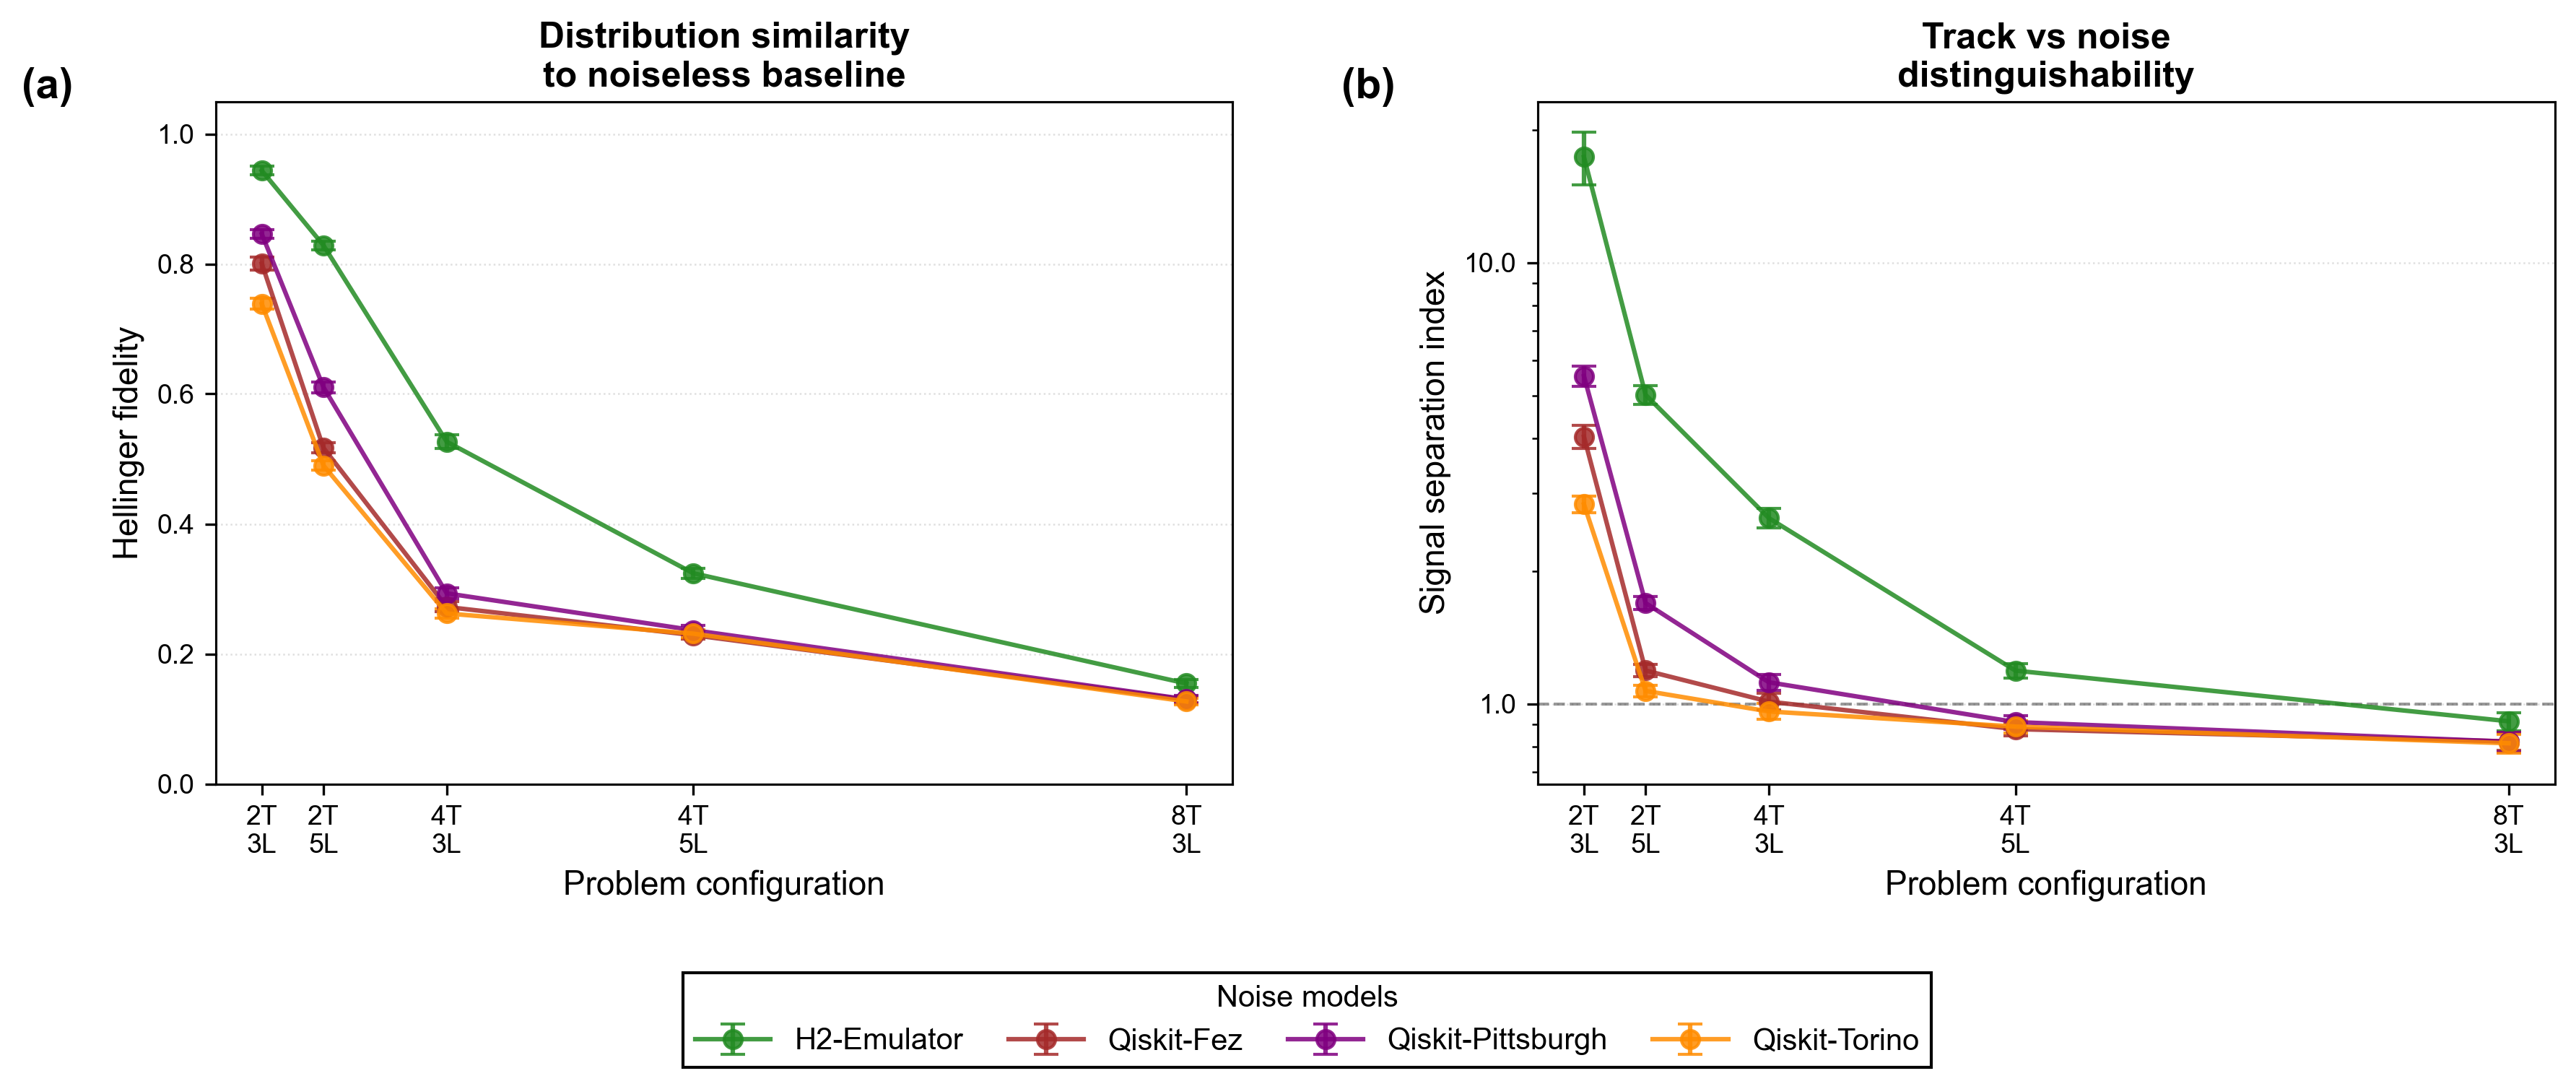

In [4]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.75

fig = plt.figure(figsize=(12, 5), dpi=300)
gs = fig.add_gridspec(1, 2, hspace=0.25, wspace=0.30,
                        left=0.08, right=0.98, top=0.88, bottom=0.25)

handles, labels = [], []

# Panel (a): Hellinger Fidelity
ax = fig.add_subplot(gs[0, 0])

for emulator in sorted(hellinger_results[scenarios[0]].keys()):
    color = emulator_colors.get(emulator, 'gray')
    
    means = []
    stds = []
    for scenario in scenarios:
        if emulator in hellinger_results[scenario]:
            means.append(hellinger_results[scenario][emulator]['mean'])
            stds.append(hellinger_results[scenario][emulator]['std'])
        else:
            means.append(np.nan)
            stds.append(0)
    
    line = ax.errorbar(x_positions, means, yerr=stds,
                        marker='o', linewidth=1.5, markersize=6, capsize=4, capthick=1.0,
                        label=emulator, color=color, alpha=0.85)
    
    if emulator not in labels:
        handles.append(line)
        labels.append(emulator)

ax.set_xlabel('Problem configuration', fontsize=11)
ax.set_ylabel('Hellinger fidelity', fontsize=11)
ax.set_title('Distribution similarity\nto noiseless baseline', fontsize=12, fontweight='bold', pad=5)
ax.set_xticks(x_positions)
ax.set_xticklabels(x_tick_labels, fontsize=9)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.4, axis='y', linestyle=':', linewidth=0.6)
ax.tick_params(labelsize=9)
ax.text(-0.14, 1.05, '(a)', transform=ax.transAxes,
        fontsize=14, fontweight='bold', va='top', ha='right')

# Panel (b): Signal Separation Index
ax = fig.add_subplot(gs[0, 1])

for emulator in sorted(ssi_results[scenarios[0]].keys()):
    color = emulator_colors.get(emulator, 'gray')
    
    means = []
    stds = []
    for scenario in scenarios:
        if emulator in ssi_results[scenario]:
            means.append(ssi_results[scenario][emulator]['mean'])
            stds.append(ssi_results[scenario][emulator]['std'])
        else:
            means.append(np.nan)
            stds.append(0)
    
    ax.errorbar(x_positions, means, yerr=stds,
                marker='o', linewidth=1.5, markersize=6, capsize=4, capthick=1.0,
                label=emulator, color=color, alpha=0.85)

ax.set_xlabel('Problem configuration', fontsize=11)
ax.set_ylabel('Signal separation index', fontsize=11)
ax.set_title('Track vs noise\ndistinguishability', fontsize=12, fontweight='bold', pad=5)
ax.set_xticks(x_positions)
ax.set_xticklabels(x_tick_labels, fontsize=9)
ax.set_yscale('log')
ax.axhline(y=1, color='black', linestyle='--', linewidth=1.0, alpha=0.4)
ax.grid(True, alpha=0.4, axis='y', linestyle=':', linewidth=0.6)
ax.tick_params(labelsize=9)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(axis='y', style='plain')
ax.text(-0.14, 1.05, '(b)', transform=ax.transAxes,
        fontsize=14, fontweight='bold', va='top', ha='right')

# Legend
fig.legend(handles, labels, loc='lower center', 
            bbox_to_anchor=(0.5, -0.02),
            fontsize=10, framealpha=0.98, 
            title='Noise models', title_fontsize=10,
            ncol=len(handles), borderaxespad=0.3,
            columnspacing=1.5, handlelength=2.5,
            edgecolor='black', fancybox=False, frameon=True)

# Save
plt.savefig("plots/hellinger_ssi_analysis.pdf", dpi=600, bbox_inches='tight')
plt.savefig("plots/hellinger_ssi_analysis.jpeg", dpi=600, bbox_inches='tight')
plt.show()

plt.rcParams.update(plt.rcParamsDefault)